# Rede Neural Recorrente simples para classificar dígitos MNIST

O experimento deste notebook foi modificado para ser uma RNN sequencial 
com 28 linhas de 28 pixels para cada amostra. O experimento original
trata um pixel de cada vez.

**Obs:** This is a reproduction of the IRNN experiment
with pixel-by-pixel sequential MNIST in
"A Simple Way to Initialize Recurrent Networks of Rectified Linear Units"
by Quoc V. Le, Navdeep Jaitly, Geoffrey E. Hinton
arxiv:1504.00941v2 [cs.NE] 7 Apr 2015
http://arxiv.org/pdf/1504.00941v2.pdf
Optimizer is replaced with RMSprop which yields more stable and steady
improvement.
Reaches 0.93 train/test accuracy after 900 epochs
(which roughly corresponds to 1687500 steps in the original paper.)

## Importação

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import torch
import torch.nn as nn

import torchvision

import lib.pytorch_trainer as ptt

## Leitura do dataset

In [ ]:
dataset_dir = '/data/datasets/MNIST/'

x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')
x_test,  y_test  = torch.load(dataset_dir + 'processed/test.pt')

x_train = x_train.float()
x_test  = x_test.float()

x_train = x_train / 255.
x_test  = x_test  / 255.

## Pouquíssimas amostras - depurando apenas

In [3]:
if True:
    n_samples_train = 1000
    n_samples_test  = 500

    x_train = x_train[:n_samples_train]
    y_train = y_train[:n_samples_train]
    x_test  = x_test[:n_samples_test]
    y_test  = y_test[:n_samples_test]

In [4]:
x_train.shape

torch.Size([1000, 28, 28])

## SimpleRNN com 100 neurônios

In [ ]:
class Model_RNN(nn.Module):
    def __init__(self, hidden_size):
        super(Model_RNN, self).__init__()
        self.hidden_size = hidden_size

        self.rnn = nn.RNN(28, hidden_size, 1, dropout=0.05)
        self.out = nn.Linear(hidden_size, 10)

    def step(self, input, hidden=None):
        input = self.inp(input.view(1, -1)).unsqueeze(1)
        output, hidden = self.rnn(input, hidden)
        output = self.out(output.squeeze(1))
        return output, hidden

    def forward(self, inputs, hidden=None, steps=28):
        if force or steps == 0: steps = len(inputs)
        outputs = Variable(torch.zeros(steps, 1, 1))
        for i in range(steps):
            if force or i == 0:
                input = inputs[i]
            else:
                input = output
            output, hidden = self.step(input, hidden)
            outputs[i] = output
        return outputs, hidden
        

In [10]:
model = Sequential()
model.add(SimpleRNN(100,
                    kernel_initializer=initializers.RandomNormal(stddev=0.001),
                    recurrent_initializer=initializers.Identity(gain=1.0),
                    activation='relu',
                    input_shape=x_train.shape[1:]))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 100)               12900     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 13,910
Trainable params: 13,910
Non-trainable params: 0
_________________________________________________________________


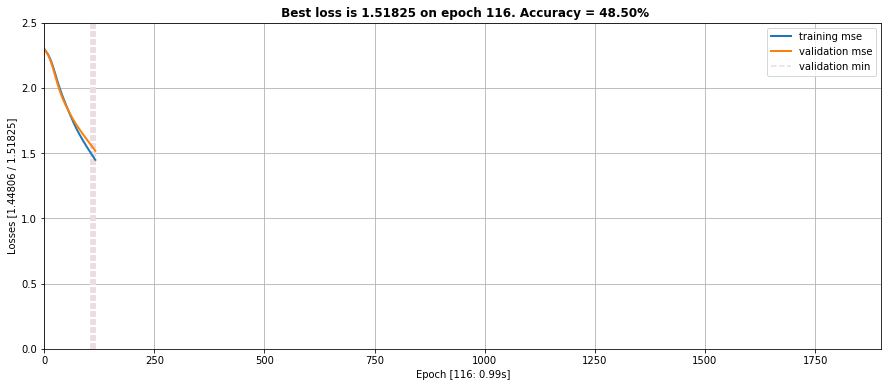

In [11]:
model_name = '../../models/SimpleRNN_MNIST'
fit_params = {
    'model_name': model_name,
    'loss': 'categorical_crossentropy',
    'opt':        RMSprop(lr=1e-6),
    'batch_size': 32, 
    'nepochs':    1900,
    'patience':   15,
    'ploss':      2.5,
    'reset':      False,
}

model,_ = train_network(model, x_train, y_train_oh, x_test, y_test_oh, **fit_params);

In [13]:
test_network(model_name, x_test, y_test_oh)

Model from epoch 116
[INFO] evaluating in the test data set ...
 128/1000 [==>...........................] - ETA: 0s
[INFO] accuracy on the test data set: 48.50% [1.51825]


In [14]:
yhat = model.predict_classes(x_test[0:10])

10/10 [==============================] - 0s


In [15]:
yhat

array([7, 6, 1, 6, 4, 1, 4, 8, 4, 8])

In [16]:
y_test[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=uint8)